## Pricing a European Call Option under Risk Neutrality

#### John Stachurski

Let's consider how to price a European option under the assumption of risk neutrality.

Suppose that the current time is $t=0$ and the expiry date is $n$.

We need to evaluate

$$ P_0 = \beta^n \mathbb E_0 \max\{ S_n - K, 0 \} $$

given 

* the discount factor $\beta$
* the strike price $K$
* the stochastic process $\{S_t\}$



A common model for $\{S_t\}$ is

$$ \ln \frac{S_{t+1}}{S_t} = \mu + \sigma \xi_{t+1} $$

where $\{ \xi_t \}$ is IID and standard normal.  However, its predictions are in some ways counterfactual.  For example, volatility is not stationary but rather changes over time.  Here's an improved version:

$$ \ln \frac{S_{t+1}}{S_t} = \mu + \sigma_t \xi_{t+1} $$

where 

$$ 
    \sigma_t = \exp(h_t), 
    \quad
        h_{t+1} = \rho h_t + \nu \eta_{t+1}
$$


Let's compute the price of the option $P_0$ by Monte Carlo, averaging over realizations $S_n^1, \ldots, S_n^M$ of $S_n$ and appealing to the law of large numbers:

$$ \mathbb E_0 \max\{ S_n - K, 0 \} 
    \approx
    \frac{1}{M} \sum_{m=1}^M \max \{S_n^m - K, 0 \}
    $$

In [1]:
import numpy as np
from numpy.random import randn
import numba
from numba import jit
import matplotlib.pyplot as plt

In [2]:
def simulate_asset_price_path(μ=0.005,
                               S0=100,
                               h0=0,
                               n=10,
                               ρ=0.5,
                               ν=0.01):
    s = np.empty(n+1)
    s[0] = np.log(S0)

    h = h0
    for t in range(n):
        s[t+1] = s[t] + μ + np.exp(h) * randn()
        h = ρ * h + ν * randn()
        
    return np.exp(s)

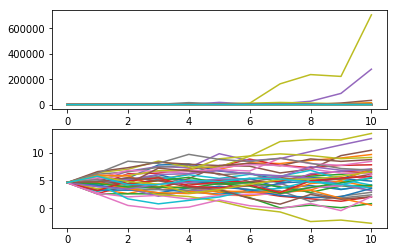

In [3]:
fig, axes = plt.subplots(2, 1)

for i in range(40):
    path = simulate_asset_price_path()
    axes[0].plot(path)
    axes[1].plot(np.log(path))
plt.show()

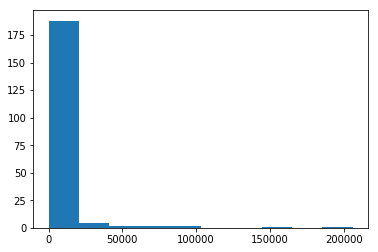

In [4]:
M = 200
K = 100
β = 0.96
n = 10
S_vals = np.empty(M)
for i in range(M):
    S_vals[i] = simulate_asset_price_path()[-1]
    
P_vals = β**n * np.maximum(S_vals - K, 0)

fig, ax = plt.subplots()
ax.hist(P_vals)

plt.show()

Here's some faster, more efficient code to compute the option price:

In [5]:
@jit(nopython=True)
def compute_call_price(β=0.96,
                       μ=0.005,
                       S0=10,
                       h0=0,
                       K=100,
                       n=10,
                       ρ=0.5,
                       ν=0.01,
                       M=1_000_000):
    current_sum = 0.0
    for m in range(M):
        s = np.log(S0)
        h = h0
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
        current_sum += np.maximum(np.exp(s) - K, 0)
        
    return β**n + current_sum / M

In [6]:
timeit compute_call_price()

1.17 s ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's try to parallelize this task.

In [7]:
@jit(nopython=True, parallel=True)
def compute_call_price_parallel(β=0.96,
                                   μ=0.005,
                                   S0=10,
                                   h0=0,
                                   K=100,
                                   n=10,
                                   ρ=0.5,
                                   ν=0.01,
                                   M=1_000_000):
    current_sum = 0.0
    for m in numba.prange(M):
        s = np.log(S0)
        h = h0
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
        current_sum += np.maximum(np.exp(s) - K, 0)
        
    return β**n + current_sum / M

In [8]:
timeit compute_call_price_parallel()

340 ms ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


That's a nice speed up, even on my laptop with 2 cores!